# 1. Load and parse the data
#### Code is primarily from Lydia's FICO-figures.ipynb 

In [203]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [204]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# import all of our files
import sys
sys.path.append('../')
import Liu_paper_code.fico as fico
import Liu_paper_code.distribution_to_loans_outcomes as dlo
from scripts.data_creation_utils import get_pmf,get_repay_probabilities,get_scores
from scripts.evaluation_utils import inspect_MinMax
from scripts.visualization_utils import visualize_data_distribution, visual_scores_by_race, visual_repay_dist
# imports for my own code
import pandas as pd
from random import choices



In [205]:
# Parameters
data_dir = '../data/raw/'
results_dir = '../data/final/'
file_name = 'balanced_set_mayor_repay_decrease.csv'
round_num_scores = 2
round_num_repay_probs = 1
order_of_magnitude = 100000
group_size_ratio = [0.5,0.5]

In [206]:
# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

In [207]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir);

In [208]:
cdfs = all_cdfs[["White","Black"]]

# B is White
# A is Black

cdf_B = cdfs['White'].values
cdf_A = cdfs['Black'].values

repay_B = performance['White']
repay_A = performance['Black']
scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index


In [209]:
# basic parameters
N_scores = cdf_B.size
N_groups = 2

# get probability mass functions of each group
pi_A = get_pmf(cdf_A)
pi_B = get_pmf(cdf_B)
pis = np.vstack([pi_A, pi_B])

# demographic statistics 
group_ratio = np.array((totals["Black"], totals["White"]))
#group_size_ratio = group_ratio/group_ratio.sum() - true fico data goup size ratio
#print(group_size_ratio)

In [210]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]

# unpacking repay probability as a function of score
loan_repay_fns = [lambda x: loan_repaid_prob(x) for
                      loan_repaid_prob in loan_repaid_probs]

## 2.1 Convert the data in format needed
The parameter round_num designates if we will round the credit scores and/or probabilities to a certain degree.<br> 
round_num = {0,1,2} <br> 
* 0: don't round at all (we don't recommend this) <br>
* 1: round to the hundreth decimal <br>
* 2: round to the nearest integer (no decimals left)

In [211]:
# Make repay probabilities into percentages from decimals
# NOTE: A is Black, B is White
scores_arr = np.asarray(get_scores(scores=scores_list, round_num=2)) # we recommend 1 or 2 for round_num
print(scores_arr)
repay_A_arr = pd.Series.to_numpy(repay_A)*100
repay_B_arr = pd.Series.to_numpy(repay_B)*100

[300. 312. 324. 336. 348. 355. 361. 367. 373. 379. 385. 390. 396. 402.
 406. 411. 416. 420. 425. 430. 434. 439. 444. 448. 452. 456. 460. 464.
 468. 472. 475. 479. 483. 487. 491. 495. 498. 502. 505. 508. 511. 515.
 518. 521. 524. 527. 530. 534. 537. 540. 543. 546. 549. 552. 555. 557.
 560. 562. 565. 568. 570. 573. 576. 578. 581. 583. 586. 589. 591. 594.
 596. 599. 601. 603. 605. 608. 610. 612. 614. 616. 618. 620. 622. 624.
 626. 628. 630. 632. 635. 637. 639. 641. 643. 645. 647. 649. 651. 653.
 655. 657. 658. 660. 662. 664. 666. 667. 669. 671. 673. 675. 676. 678.
 680. 682. 684. 686. 687. 689. 691. 693. 695. 696. 698. 700. 701. 703.
 704. 706. 707. 709. 710. 712. 713. 715. 716. 718. 719. 721. 722. 724.
 725. 726. 728. 729. 731. 734. 735. 737. 738. 740. 741. 743. 744. 746.
 749. 750. 752. 753. 755. 756. 758. 759. 761. 763. 764. 766. 767. 769.
 771. 772. 774. 775. 777. 778. 780. 782. 783. 785. 786. 788. 790. 791.
 793. 796. 797. 799. 802. 806. 811. 815. 819. 824. 828. 832. 837. 841.
 846. 

## 2.2 Sample from the data 
The group size ratio is [0.12066905, 0.87933095]. We need the samples to follow that ratio.

In [212]:
# Sample data according to the pmf
# Reference: https://www.w3schools.com/python/ref_random_choices.asp

num_A_samples = int(group_size_ratio[0] * order_of_magnitude)
num_B_samples = int(group_size_ratio[1] * order_of_magnitude)

samples_A = np.asarray(sorted(choices(scores_arr, pi_A, k=num_A_samples)))
samples_B = np.asarray(sorted(choices(scores_arr, pi_B, k=num_B_samples)))

## 2.3 Combine the scores and probabilities and convert data types
We use round_num with a value of 1 so that we have two decimals for the probabilities. We think rounding to the nearest integer would lead to us losing important data. 

In [213]:
# Calculate samples groups' probabilities and make arrays for race
# A == Black == 0 (later defined as 0.0 when converting to pandas df)
# B == White == 1 (later defined as 1.0 when converting to pandas df)

samples_A_probs = get_repay_probabilities(samples=samples_A,scores_arr=scores_arr, repay_probs=repay_A_arr, round_num=1)*0.5
samples_A_race = np.zeros(num_A_samples, dtype= int)

samples_B_probs = get_repay_probabilities(samples=samples_B,scores_arr=scores_arr,  repay_probs=repay_B_arr, round_num=1)
samples_B_race = np.ones(num_B_samples, dtype= int)

# Get data in dict form with score and repay prob
data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs} #,'race': samples_A_race}
data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs} #,'race': samples_B_race}

# Get data in dict form with score, repay prob, and race
data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs ,'race': samples_A_race}
data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs,'race': samples_B_race}

# Convert from dict to df
data_A_df = pd.DataFrame(data=data_A_dict, dtype=np.float64)
data_B_df = pd.DataFrame(data=data_B_dict, dtype=np.float64)

# Combine all of the data together and shuffle
# NOTE: not currently being used but could be useful at a later time
data_all_df = pd.concat([data_A_df, data_B_df], ignore_index=True)
#print(data_all_df)
data_all_df_shuffled = data_all_df.sample(frac=1).reset_index(drop=True)
#print(data_all_df_shuffled)

In [214]:
# Add Final Column to dataframe, repay indices
# repay: 1.0, default: 0.0

# Create a random num and then have that decide given a prob if the person gets a loan or not 
# (e.g. If 80% prob, then calculate a random num, then if that is below they will get loan, if above, then they don't) 

print('Data before adding repay indices: ')
print(data_all_df_shuffled)

probabilities = data_all_df_shuffled['repay_probability']
repay_indices = []

for index, prob in enumerate(probabilities):
    rand_num = random.randint(0,1000)/10
    if rand_num > prob:  # default
        repay_indices.append(0)
    else:
        repay_indices.append(1)  # repay

data_all_df_shuffled['repay_indices'] = np.array(repay_indices)

print('Data after adding repay indices: ')
print(data_all_df_shuffled)

Data before adding repay indices: 
       score  repay_probability  race
0      460.0             17.350   1.0
1      361.0              1.470   0.0
2      630.0             37.705   0.0
3      546.0             16.790   0.0
4      680.0             43.445   0.0
...      ...                ...   ...
99995  444.0              4.770   0.0
99996  483.0              6.025   0.0
99997  511.0              7.030   0.0
99998  738.0             46.940   0.0
99999  324.0              0.600   0.0

[100000 rows x 3 columns]
Data after adding repay indices: 
       score  repay_probability  race  repay_indices
0      460.0             17.350   1.0              0
1      361.0              1.470   0.0              0
2      630.0             37.705   0.0              0
3      546.0             16.790   0.0              0
4      680.0             43.445   0.0              0
...      ...                ...   ...            ...
99995  444.0              4.770   0.0              0
99996  483.0            

## 2.4 Save the pandas dataframes to CSVs

In [215]:
data_all_df_shuffled.to_csv(index=False, path_or_buf=results_dir+file_name)

# To save the data separately by race
#data_A_df.to_csv(index=False, path_or_buf='simData_2decProbs_0decScores_groupA_black.csv')
#data_B_df.to_csv(index=False, path_or_buf='simData_2decProbs_0decScores_groupB_white.csv')

## 2.5 Inspect the min/max values of the data

In [216]:
# TODO: make a function for printing the min/max values of the respective groups for score and probability

In [217]:
inspect_MinMax(samples_A_probs,samples_B_probs)

the range of the Group A (Black) repay probabilities is:  49.245
the min value is:  0.165
the max value is:  49.41
the range of the Group B (White) repay probabilities is:  97.64
the min value is:  1.46
the max value is:  99.1


In [218]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

total_samples_A = len(samples_A)
total_samples_B = len(samples_B)
values_A = set(samples_A)
values_B = set(samples_B)
res_A = Counter(samples_A)
res_B = Counter(samples_B)

pmf_A = []
pmf_B = []
for v_A,v_B in zip(values_A,values_B):
    pmf_A.append(res_A[v_A]/total_samples_A)
    pmf_B.append(res_B[v_B]/total_samples_B)
    

count1 = 0
count2 = 0
for e1,e2 in zip(pmf_A,pmf_B):
    if e1 < 1/550:
        count1 += 1
    if e2 < 1/550:
        count2 += 1
    
print('Ratio:',count1/len(pmf_A), count2/len(pmf_B))

Ratio: 0.3299492385786802 0.02030456852791878


In [219]:
### Masuring the amount of points <1%
count1 = 0
count2 = 0
for e1,e2 in zip(samples_A_probs,samples_B_probs):
    if e1 < 1:
        count1 += 1
    if e2 < 1:
        count2 += 1
    
print('Ratio:',count1/len(samples_A_probs), count2/len(samples_B_probs))

Ratio: 0.06408 0.0


## 2.6 Visualize the data

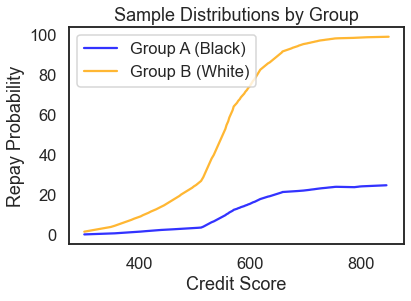

In [220]:
visualize_data_distribution(samples_A,samples_A_probs*0.5,samples_B,samples_B_probs)

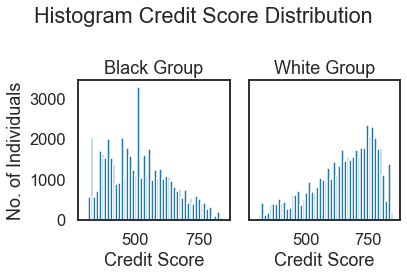

In [221]:
visual_scores_by_race(data_all_df_shuffled)

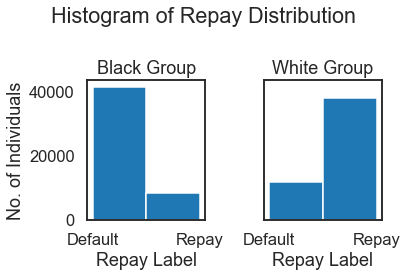

In [222]:
visual_repay_dist(data_all_df_shuffled)